In [2]:
import numpy as np
import os
import re
from scipy.signal import resample

In [2]:
os.chdir("C:\\Users/Bridget Leonard/Desktop/BridgeTower-Brain")

## Part 5: fMRI Prediction
- project features into opposite modal space with feature alignment
- predict fMRI activity using features

## 1 Feature alignment matrices

### 1.1 Load the matrices
These matrices were calculated in part 3. They represent the linear relationship between image and caption pairs. The image-->caption matrices were estimated by predicting each language feature from visual features, the caption--> image matrices were estimated by predicting each visual feature from the language features. Thus we have two matrices with size [768, 768] where each column represents a language or visual feature's linear relationship (beta coefficient) with each visual or language feature, respectively.

In [14]:
caption_to_image_matrices = np.load("results/feature_alignment/caption_to_image_matrices.npy")
image_to_caption_matrices = np.load("results/feature_alignment/image_to_caption_matrices.npy")

In [15]:
caption_to_image_matrices.shape

(768, 768)

### 1.2 Project data into the opposite modal space

In [16]:
# Load feature vectors
# movie data
test = np.load("results/feature_vectors/movie/test_data.npy")
train00 = np.load("results/feature_vectors/movie/train_00_data.npy")
train01 = np.load("results/feature_vectors/movie/train_01_data.npy")
train02 = np.load("results/feature_vectors/movie/train_02_data.npy")
train03 = np.load("results/feature_vectors/movie/train_03_data.npy")
train04 = np.load("results/feature_vectors/movie/train_04_data.npy")
train05 = np.load("results/feature_vectors/movie/train_05_data.npy")
train06 = np.load("results/feature_vectors/movie/train_06_data.npy")
train07 = np.load("results/feature_vectors/movie/train_07_data.npy")
train08 = np.load("results/feature_vectors/movie/train_08_data.npy")
train09 = np.load("results/feature_vectors/movie/train_09_data.npy")
train10 = np.load("results/feature_vectors/movie/train_10_data.npy")
train11 = np.load("results/feature_vectors/movie/train_11_data.npy")

# story data
alternateithicatom = np.load("results/feature_vectors/story/alternateithicatom_data.npy")
avatar = np.load("results/feature_vectors/story/avatar_data.npy")
howtodraw = np.load("results/feature_vectors/story/howtodraw_data.npy")
legacy = np.load("results/feature_vectors/story/legacy_data.npy")
life = np.load("results/feature_vectors/story/life_data.npy")
myfirstdaywiththeyankees = np.load("results/feature_vectors/story/myfirstdaywiththeyankees_data.npy")
naked = np.load("results/feature_vectors/story/naked_data.npy")
odetostepfather = np.load("results/feature_vectors/story/odetostepfather_data.npy")
souls = np.load("results/feature_vectors/story/souls_data.npy")
undertheinfluence = np.load("results/feature_vectors/story/undertheinfluence_data.npy")

Visual to text: Movie data

In [17]:
test_transformed = np.dot(test, image_to_caption_matrices.T)
train00_transformed = np.dot(train00, image_to_caption_matrices.T)
train01_transformed = np.dot(train01, image_to_caption_matrices.T)
train02_transformed = np.dot(train02, image_to_caption_matrices.T)
train03_transformed = np.dot(train03, image_to_caption_matrices.T)
train04_transformed = np.dot(train04, image_to_caption_matrices.T)
train05_transformed = np.dot(train05, image_to_caption_matrices.T)
train06_transformed = np.dot(train06, image_to_caption_matrices.T)
train07_transformed = np.dot(train07, image_to_caption_matrices.T)
train08_transformed = np.dot(train08, image_to_caption_matrices.T)
train09_transformed = np.dot(train09, image_to_caption_matrices.T)
train10_transformed = np.dot(train10, image_to_caption_matrices.T)
train11_transformed = np.dot(train11, image_to_caption_matrices.T)

Text to visual: Story data

In [18]:
alternateithicatom_transformed = np.dot(alternateithicatom, caption_to_image_matrices.T)
avatar_transformed = np.dot(avatar, caption_to_image_matrices.T)
howtodraw_transformed = np.dot(howtodraw, caption_to_image_matrices.T)
legacy_transformed = np.dot(legacy, caption_to_image_matrices.T)
life_transformed = np.dot(life, caption_to_image_matrices.T)
myfirstdaywiththeyankees_transformed = np.dot(myfirstdaywiththeyankees, caption_to_image_matrices.T)
naked_transformed = np.dot(naked, caption_to_image_matrices.T)
odetostepfather_transformed = np.dot(odetostepfather, caption_to_image_matrices.T)
souls_transformed = np.dot(souls, caption_to_image_matrices.T)
undertheinfluence_transformed = np.dot(undertheinfluence, caption_to_image_matrices.T)

## 2 Load voxelwise encoding models
These matrices were calculated in part 4.

### 2.1 Define functions

In [8]:
os.getcwd()

'C:\\Users\\Bridget Leonard\\Desktop\\BridgeTower-Brain'

In [9]:
# Function to extract the starting voxel number from the file name
def extract_start_number(filename):
    match = re.search(r'(\d+)-\d+\.npy$', filename)
    if match:
        return int(match.group(1))
    # Handle files with underscores
    match = re.search(r'(\d+)_\d+\.npy$', filename)
    if match:
        return int(match.group(1))
    return 0

In [14]:
def find_file_for_voxel(voxel_number):
    for filename in npy_files:
        # Extract the start and end numbers from the filename
        match = re.search(r'(\d+)_(\d+)\.npy', filename)
        if match:
            start_num, end_num = int(match.group(1)), int(match.group(2))
            # Check if the voxel number falls within the range
            if start_num <= voxel_number <= end_num:
                # Calculate the index of the voxel within the file
                voxel_index_within_file = voxel_number - start_num
                return filename, voxel_index_within_file
    return None, None

In [15]:
def test_final_matrix(voxel, directory_path, encoding_matrix):
    file_name, voxel_index = find_file_for_voxel(voxel)
    file = np.load(os.path.join(directory_path, file_name))
    assert np.array_equal(file[voxel_index], encoding_matrix[:, voxel]), "Voxel coefficients do not match"

### 2.2 Vision encoding model

In [10]:
# Path to the directory containing the .npy files
directory_path = 'results/encoding_model/movie/coefficients'

# List all .npy files and sort them based on the starting voxel number
npy_files = [f for f in os.listdir(directory_path) if f.endswith('.npy')]
npy_files.sort(key=extract_start_number)

In [11]:
npy_files[:10]

['coefficients_0_1599.npy',
 'coefficients_1600_3199.npy',
 'coefficients_3200_4799.npy',
 'coefficients_4800_6399.npy',
 'coefficients_6400_7999.npy',
 'coefficients_8000_9599.npy',
 'coefficients_9600_11199.npy',
 'coefficients_11200_12799.npy',
 'coefficients_12800_14399.npy',
 'coefficients_14400_15999.npy']

In [12]:
# Initialize an empty list to hold the data arrays
data_arrays = []

for file_name in npy_files:
    # Load the current batch and transpose it
    batch_data = np.load(os.path.join(directory_path, file_name)).T  # Transpose here
    data_arrays.append(batch_data)

# Combine all the transposed batches into one final matrix
# Note: np.concatenate operates along the first axis by default, so this aligns with our goal
vision_matrix = np.concatenate(data_arrays, axis=1)

In [13]:
npy_files

['coefficients_0_1599.npy',
 'coefficients_1600_3199.npy',
 'coefficients_3200_4799.npy',
 'coefficients_4800_6399.npy',
 'coefficients_6400_7999.npy',
 'coefficients_8000_9599.npy',
 'coefficients_9600_11199.npy',
 'coefficients_11200_12799.npy',
 'coefficients_12800_14399.npy',
 'coefficients_14400_15999.npy',
 'coefficients_16000_17599.npy',
 'coefficients_17600_19199.npy',
 'coefficients_19200_20799.npy',
 'coefficients_20800_22399.npy',
 'coefficients_22400_23999.npy',
 'coefficients_24000_25599.npy',
 'coefficients_25600_27199.npy',
 'coefficients_27200_28799.npy',
 'coefficients_28800_30399.npy',
 'coefficients_30400_31999.npy',
 'coefficients_32000_33599.npy',
 'coefficients_33600_35199.npy',
 'coefficients_35200_36799.npy',
 'coefficients_36800_38399.npy',
 'coefficients_38400_39999.npy',
 'coefficients_40000_41599.npy',
 'coefficients_41600_43199.npy',
 'coefficients_43200_44799.npy',
 'coefficients_44800_46399.npy',
 'coefficients_46400_47999.npy',
 'coefficients_48000_49599

In [16]:
test_final_matrix(0)
test_final_matrix(47800)

In [17]:
vision_matrix.shape

(3072, 81600)

In [18]:
# Find columns that are not all zeroes
not_all_zeroes = np.any(vision_matrix != 0, axis=0)

# Filter out columns that are all zeroes
final_matrix = vision_matrix[:, not_all_zeroes]

print(final_matrix.shape)

(3072, 81111)


### 2.3 Language Encoding Model

In [36]:
language_encoding = np.load("results/encoding_model/story/S1_coefficients.npy")

In [37]:
language_encoding.shape

(768, 81111)

In [38]:
np.all(language_encoding == 0)

False

## 3 Using the vision encoding model to predict fMRI responses to stories
We'll be using the tranformed story data above to predict the fMRI data found in `data/fmri_data/storydata/S1`

### 3.1 Load fMRI data

In [19]:
s1_alternateithicatom = np.load("data/fmri_data/storydata/S1/alternateithicatom.npy")
s1_avatar = np.load("data/fmri_data/storydata/S1/avatar.npy")
s1_howtodraw = np.load("data/fmri_data/storydata/S1/howtodraw.npy")
s1_legacy = np.load("data/fmri_data/storydata/S1/legacy.npy")
s1_life = np.load("data/fmri_data/storydata/S1/life.npy")
s1_myfirstdaywiththeyankees = np.load("data/fmri_data/storydata/S1/myfirstdaywiththeyankees.npy")
s1_naked = np.load("data/fmri_data/storydata/S1/naked.npy")
s1_odetostepfather = np.load("data/fmri_data/storydata/S1/odetostepfather.npy")
s1_souls = np.load("data/fmri_data/storydata/S1/souls.npy")
s1_undertheinfluence = np.load("data/fmri_data/storydata/S1/undertheinfluence.npy")

### 3.2 Start with first story

In [20]:
s1_alternateithicatom.shape

(363, 31, 100, 100)

In [9]:
def remove_nan(data):
    mask = ~np.isnan(data)

    # Apply the mask and then flatten
    # This will keep only the non-NaN values
    data_reshaped = data[mask].reshape(data.shape[0], -1)
    
    print("fMRI shape:", data_reshaped.shape)
    return data_reshaped

In [22]:
s1_ai_reshaped = remove_nan(s1_alternateithicatom)

fMRI shape: (363, 81111)


#### 3.2.1 Resample to fMRI acquisition

In [23]:
alternateithicatom_transformed.shape

(2681, 768)

In [24]:
def resample_to_acq(feature_data, fmri_data):
    dimensions = fmri_data.shape[0]
    data_transposed = feature_data.T
    data_resampled = np.empty((data_transposed.shape[0], dimensions))

    for i in range(data_transposed.shape[0]):
        data_resampled[i, :] = resample(data_transposed[i, :], dimensions, window=('kaiser', 14))
    
    print("Shape after resampling:", data_resampled.T.shape)
    return data_resampled.T

In [25]:
alternateithicatom_resampled = resample_to_acq(alternateithicatom_transformed, s1_ai_reshaped)

Shape after resampling: (363, 768)


#### 3.2.2 Delay the features

In [26]:
def delay_features(features):
    delays = [2, 4, 6, 8]  # Delays in seconds
    shifted_features_list = []

    for delay in delays:
        shift_amount = delay // 2  # Assuming TR is 2 seconds
        shifted = np.roll(features, shift_amount, axis=0)
        # Optionally, handle edge effects here (e.g., zero-padding or trimming)
        shifted_features_list.append(shifted)

    # Stack the shifted arrays to create a 3D array
    shifted_features_3d = np.stack(shifted_features_list, axis=-1)
    
    # Reshape the feature data for regression
    n_time_points, n_features, n_delays = shifted_features_3d.shape
    features_reshaped = shifted_features_3d.reshape(n_time_points, n_features * n_delays)

    print("Shape after delays:", features_reshaped.shape)
    return features_reshaped

In [27]:
ai_resamp_delay = delay_features(alternateithicatom_resampled)

Shape after delays: (363, 3072)


#### 3.2.3 Create overall function to prepare feature and fmri data

In [28]:
def prep_data(fmri_data, feature_data):
    fmri_reshaped = remove_nan(fmri_data)

    feature_resampled = resample_to_acq(feature_data, fmri_reshaped)
    feature_delayed = delay_features(feature_resampled)

    return fmri_reshaped, feature_delayed

#### 3.2.4 Generate fMRI predictions

In [29]:
s1_ai_fmri, s1_ai_features = prep_data(s1_alternateithicatom, alternateithicatom_transformed)

fMRI shape: (363, 81111)
Shape after resampling: (363, 768)
Shape after delays: (363, 3072)


In [30]:
s1_ai_predictions = np.dot(s1_ai_features, final_matrix)

In [11]:
def safe_correlation(x, y):
    """Calculate the Pearson correlation coefficient safely."""
    # Mean centering
    x_mean = x - np.mean(x)
    y_mean = y - np.mean(y)
    
    # Numerator: sum of the product of mean-centered variables
    numerator = np.sum(x_mean * y_mean)
    
    # Denominator: sqrt of the product of the sums of squared mean-centered variables
    denominator = np.sqrt(np.sum(x_mean**2) * np.sum(y_mean**2))
    
    # Safe division
    if denominator == 0:
        # Return NaN or another value to indicate undefined correlation
        return np.nan
    else:
        return numerator / denominator


In [12]:
def calc_correlation(predicted_fMRI, real_fMRI):
    # Calculate correlations for each voxel
    correlation_coefficients = np.array([safe_correlation(predicted_fMRI[:, i], real_fMRI[:, i]) for i in range(predicted_fMRI.shape[1])])

    # Check for NaNs in the result to identify voxels with undefined correlations
    nans_in_correlations = np.isnan(correlation_coefficients).any()
    print(f"NaNs in correlation coefficients: {nans_in_correlations}")

    return correlation_coefficients

In [33]:
s1_ai_correlations = calc_correlation(s1_ai_predictions, s1_ai_fmri)

NaNs in correlation coefficients: True


### 3.3 Generate a function to run through full correlation analysis

In [34]:
def predict_and_corr(fmri_data, feature_data, encoding_matrix):
    fmri_reshaped, feature_delayed = prep_data(fmri_data, feature_data)
    predicted_fmri = np.dot(feature_delayed, encoding_matrix)
    correlation = calc_correlation(predicted_fmri, fmri_reshaped)
    print(np.nanmax(correlation))
    return correlation

In [35]:
s1_ai_correlations = predict_and_corr(s1_alternateithicatom, alternateithicatom_transformed, final_matrix)

fMRI shape: (363, 81111)
Shape after resampling: (363, 768)
Shape after delays: (363, 3072)
NaNs in correlation coefficients: True
0.36196507671486794


In [36]:
s1_avatar_correlations = predict_and_corr(s1_avatar, avatar_transformed, final_matrix)
s1_howtodraw_correlations = predict_and_corr(s1_howtodraw, howtodraw_transformed, final_matrix)
s1_legacy_correlations = predict_and_corr(s1_legacy, legacy_transformed, final_matrix)
s1_life_correlations = predict_and_corr(s1_life, life_transformed, final_matrix)
s1_yankees_correlations = predict_and_corr(s1_myfirstdaywiththeyankees, myfirstdaywiththeyankees_transformed, final_matrix)
s1_naked_correlations = predict_and_corr(s1_naked, naked_transformed, final_matrix)
s1_ode_correlations = predict_and_corr(s1_odetostepfather, odetostepfather_transformed, final_matrix)
s1_souls_correlations = predict_and_corr(s1_souls, souls_transformed, final_matrix)
s1_under_correlations = predict_and_corr(s1_undertheinfluence, undertheinfluence_transformed, final_matrix)

fMRI shape: (387, 81111)
Shape after resampling: (387, 768)
Shape after delays: (387, 3072)
NaNs in correlation coefficients: True
0.40304479820845945
fMRI shape: (374, 81111)
Shape after resampling: (374, 768)
Shape after delays: (374, 3072)
NaNs in correlation coefficients: False
0.4150796918910574
fMRI shape: (420, 81111)
Shape after resampling: (420, 768)
Shape after delays: (420, 3072)
NaNs in correlation coefficients: False
0.3398571936128742
fMRI shape: (450, 81111)
Shape after resampling: (450, 768)
Shape after delays: (450, 3072)
NaNs in correlation coefficients: False
0.30989681940801767
fMRI shape: (378, 81111)
Shape after resampling: (378, 768)
Shape after delays: (378, 3072)
NaNs in correlation coefficients: True
0.33527138585387634
fMRI shape: (442, 81111)
Shape after resampling: (442, 768)
Shape after delays: (442, 3072)
NaNs in correlation coefficients: True
0.32265857428990086
fMRI shape: (424, 81111)
Shape after resampling: (424, 768)
Shape after delays: (424, 3072)
N

In [37]:
all_correlations = np.stack((s1_ai_correlations, s1_avatar_correlations, s1_howtodraw_correlations, s1_legacy_correlations, s1_life_correlations,
                             s1_yankees_correlations, s1_naked_correlations, s1_ode_correlations, s1_souls_correlations, s1_under_correlations))
average_correlation = np.nanmean(all_correlations, axis=0)

In [38]:
average_correlation[:10]

array([ 0.01195322, -0.02056186,  0.02949554,  0.03822953,  0.03202731,
        0.02950777,  0.02026067,  0.03076557, -0.00979232, -0.00758311])

In [39]:
average_correlation.shape

(81111,)

In [89]:
np.nanmax(average_correlation)

0.1194966100441407

### 3.4 Visualize the correlation coefficients

#### 3.4.1 Reverse flattening and masking

In [40]:
s1_alternateithicatom.shape

(363, 31, 100, 100)

In [41]:
# Recreate the mask used for flattening (assuming you have access to 's1_movie_train' or similar)
mask = ~np.isnan(s1_alternateithicatom[0])  # Using the first time point as a reference for the mask

# Initialize an empty 3D array with NaNs for the correlation data
reconstructed_correlations = np.full((31, 100, 100), np.nan)

# Flatten the mask to get the indices of the original valid (non-NaN) data points
valid_indices = np.where(mask.flatten())[0]

# Assign the correlation coefficients to their original spatial positions
for index, corr_value in zip(valid_indices, average_correlation):
    # Convert the 1D index back to 3D index in the spatial dimensions
    z, x, y = np.unravel_index(index, (31, 100, 100))
    reconstructed_correlations[z, x, y] = corr_value

reconstructed_correlations.shape

(31, 100, 100)

In [58]:
flattened_correlations = reconstructed_correlations.flatten()
flattened_correlations.shape

(310000,)

In [88]:
np.nanmax(flattened_correlations)

0.1194966100441407

#### 3.4.2 Plot the correlations

In [49]:
from nilearn import plotting, image, datasets
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

In [75]:
# Load the vertex-to-voxel mapping for a hemisphere
lh_mapping_matrix = load_npz("data/fmri_data/mappers/S1_listening_forVL_lh.npz")
lh_mapping_matrix.shape

(151191, 310000)

In [76]:
lh_vertex_correlation_data = lh_mapping_matrix.dot(flattened_correlations)
lh_vertex_coords = np.load("data/fmri_data/mappers/S1_vertex_coords_lh.npy")

In [96]:
# Load the vertex-to-voxel mapping for a hemisphere
rh_mapping_matrix = load_npz("data/fmri_data/mappers/S1_listening_forVL_rh.npz")
rh_mapping_matrix.shape

(152632, 310000)

In [97]:
rh_vertex_correlation_data = rh_mapping_matrix.dot(flattened_correlations)
rh_vertex_coords = np.load("data/fmri_data/mappers/S1_vertex_coords_rh.npy")

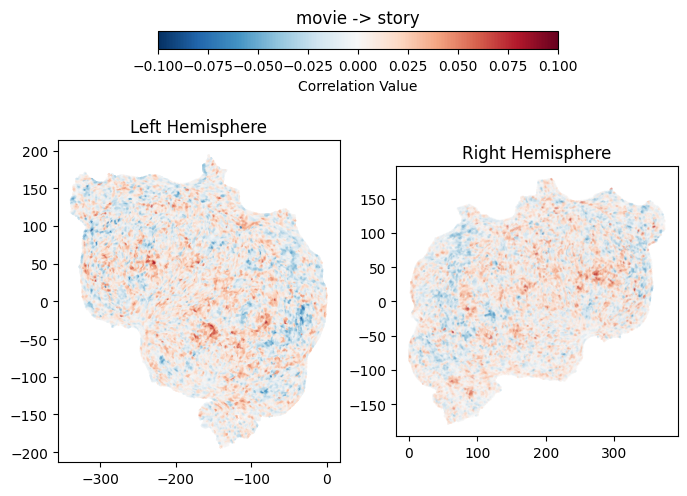

In [137]:
vmin, vmax = -0.1, 0.1
fig, axs = plt.subplots(1, 2, figsize=(8,6))

# Plot the first flatmap
sc1 = axs[0].scatter(lh_vertex_coords[:, 0], lh_vertex_coords[:, 1], c=lh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.02)
axs[0].set_aspect('equal', adjustable='box')  # Ensure equal scaling
axs[0].set_title('Left Hemisphere')
# plt.colorbar(sc1, ax=axs[0])  # Add a colorbar for the first plot

# Plot the second flatmap
sc2 = axs[1].scatter(rh_vertex_coords[:, 0], rh_vertex_coords[:, 1], c=rh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.005)
axs[1].set_aspect('equal', adjustable='box')  # Ensure equal scaling
axs[1].set_title('Right Hemisphere')
# plt.colorbar(sc2, ax=axs[1])  # Add a colorbar for the second plot

# Adjust layout to make space for the top colorbar
plt.subplots_adjust(top=0.85)

# Add a single horizontal colorbar at the top
cbar_ax = fig.add_axes([0.25, 0.9, 0.5, 0.03])  # Adjust these values as needed [left, bottom, width, height]
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation Value')

plt.title("movie -> story")
plt.show()

#### 3.4.3 Compare to paper results
<img src="literature/s1_movie_story.jpg" width="600">

## 4 Using the language encoding model to predict fMRI responses to movies

### 4.1 Load fMRI data

In [64]:
s1_train_nan = np.load("data/fmri_data/moviedata/S1/train.npy")
s1_test_nan = np.load("data/fmri_data/moviedata/S1/test.npy")

In [65]:
s1_train = remove_nan(s1_train_nan)
s1_test = remove_nan(s1_test_nan)

fMRI shape: (3600, 81111)
fMRI shape: (270, 81111)


### 4.2 Combine the data for prediction

In [66]:
s1_fmri_arrays = [s1_train, s1_test]
s1_feature_arrays = [train00_transformed, train01_transformed, train02_transformed,
                  train03_transformed, train04_transformed, train05_transformed,
                  train06_transformed, train07_transformed, train08_transformed,
                  train09_transformed, train10_transformed, train11_transformed,
                  test_transformed]

# Combine data
s1_fmri = np.vstack(s1_fmri_arrays)
s1_features = np.vstack(s1_feature_arrays)

### 4.3 Make predictions

In [21]:
s1_features.shape

(3870, 768)

In [40]:
s1_predictions = np.dot(s1_features, language_encoding)

In [41]:
s1_predictions.shape

(3870, 81111)

In [42]:
s1_correlations = calc_correlation(s1_predictions, s1_fmri)

NaNs in correlation coefficients: False


In [43]:
s1_correlations.shape

(81111,)

In [44]:
np.nanmax(s1_correlations)

0.19463641338786808

### 4.4 Visualize results

#### 4.4.1 Reverse flattening and masking

In [67]:
# Recreate the mask used for flattening (assuming you have access to 's1_movie_train' or similar)
mask = ~np.isnan(s1_train_nan[0])  # Using the first time point as a reference for the mask

# Initialize an empty 3D array with NaNs for the correlation data
reconstructed_correlations = np.full((31, 100, 100), np.nan)

# Flatten the mask to get the indices of the original valid (non-NaN) data points
valid_indices = np.where(mask.flatten())[0]

# Assign the correlation coefficients to their original spatial positions
for index, corr_value in zip(valid_indices, s1_correlations):
    # Convert the 1D index back to 3D index in the spatial dimensions
    z, x, y = np.unravel_index(index, (31, 100, 100))
    reconstructed_correlations[z, x, y] = corr_value

reconstructed_correlations.shape

(31, 100, 100)

In [68]:
flattened_correlations = reconstructed_correlations.flatten()
flattened_correlations.shape

(310000,)

In [69]:
np.nanmax(flattened_correlations)

0.19463641338786808

#### 4.4.2 Plot correlations

In [70]:
# Load the vertex-to-voxel mapping for a hemisphere
lh_mapping_matrix = load_npz("data/fmri_data/mappers/S1_listening_forVL_lh.npz")
lh_mapping_matrix.shape

(151191, 310000)

In [71]:
lh_vertex_correlation_data = lh_mapping_matrix.dot(flattened_correlations)
lh_vertex_coords = np.load("data/fmri_data/mappers/S1_vertex_coords_lh.npy")

In [72]:
# Load the vertex-to-voxel mapping for a hemisphere
rh_mapping_matrix = load_npz("data/fmri_data/mappers/S1_listening_forVL_rh.npz")
rh_mapping_matrix.shape

(152632, 310000)

In [73]:
rh_vertex_correlation_data = rh_mapping_matrix.dot(flattened_correlations)
rh_vertex_coords = np.load("data/fmri_data/mappers/S1_vertex_coords_rh.npy")

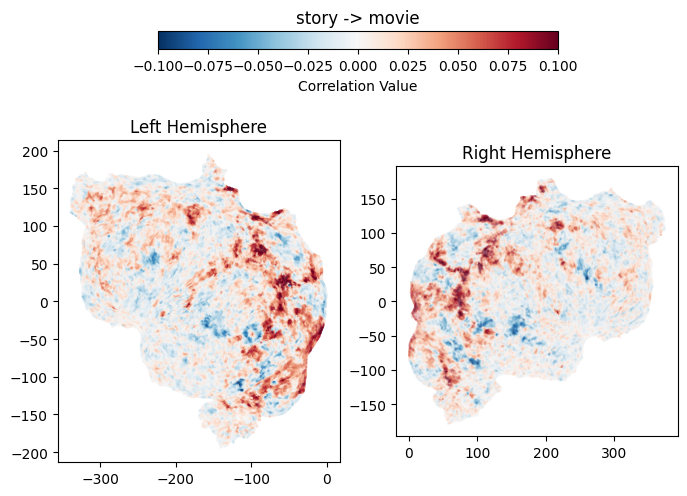

In [74]:
vmin, vmax = -0.1, 0.1
fig, axs = plt.subplots(1, 2, figsize=(8,6))

# Plot the first flatmap
sc1 = axs[0].scatter(lh_vertex_coords[:, 0], lh_vertex_coords[:, 1], c=lh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.02)
axs[0].set_aspect('equal', adjustable='box')  # Ensure equal scaling
axs[0].set_title('Left Hemisphere')
# plt.colorbar(sc1, ax=axs[0])  # Add a colorbar for the first plot

# Plot the second flatmap
sc2 = axs[1].scatter(rh_vertex_coords[:, 0], rh_vertex_coords[:, 1], c=rh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.005)
axs[1].set_aspect('equal', adjustable='box')  # Ensure equal scaling
axs[1].set_title('Right Hemisphere')
# plt.colorbar(sc2, ax=axs[1])  # Add a colorbar for the second plot

# Adjust layout to make space for the top colorbar
plt.subplots_adjust(top=0.85)

# Add a single horizontal colorbar at the top
cbar_ax = fig.add_axes([0.25, 0.9, 0.5, 0.03])  # Adjust these values as needed [left, bottom, width, height]
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation Value')

plt.title("story -> movie")
plt.show()

#### 3.4.3 Compare to paper results
<img src="literature/s1_story_movie.jpg" width="600">